In [12]:
# Using Graph Convolutional Neural Network to classify the nodes in a graph
# Using Zachary's Karate Club dataset

# A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972.[2] 
# The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. 
# During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. 
# Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. 
# Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split.

# There are 34 nodes in the graph, each node represents a member of the Karate Club
# There are 78 edges in the graph, each edge represents a friendship between two members

# Get the sum of neighborhood features for each node by using the adjacency matrix and the feature matrix


In [ ]:
# Adjacency matrix
# 1. Is N x N matrix, where N is the number of nodes
# 2. Each row represents the neighbors of a node
# 3. Each column represents the neighbors of a node
# 4. Each element is 1 if the node is a neighbor of the other node, 0 otherwise

# Zachary's Karate Club

In [1]:
# Load data from NetworkX
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

g = nx.karate_club_graph()
g.number_of_nodes(), g.number_of_edges()


(34, 78)

In [4]:
# Get club labels for each node
club_labels = nx.get_node_attributes(g,'club')

#just show a couple of the labels
print({key:club_labels[key] for key in range(10,16)})


{10: 'Mr. Hi', 11: 'Mr. Hi', 12: 'Mr. Hi', 13: 'Mr. Hi', 14: 'Officer', 15: 'Officer'}


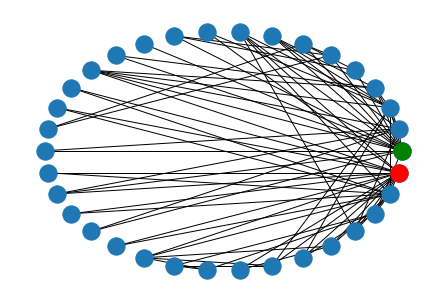

In [5]:
#Let's keep track of which nodes represent John A and Mr Hi
Mr_Hi = 0
John_A = 33

#To plot using networkx we first need to get the positions we want for each node. 
#Here we will use a ciruclar layout but there are many other variations you could choose!
circ_pos = nx.circular_layout(g) 

#Use the networkx draw function to easily visualise the graph
nx.draw(g, circ_pos)

#let's highlight Mr Hi (green) and John A (red)
nx.draw_networkx_nodes(g, circ_pos, nodelist=[Mr_Hi], node_color='g', alpha=1)
nx.draw_networkx_nodes(g, circ_pos, nodelist=[John_A], node_color='r', alpha=1)

In [34]:
from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(g)

colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]

Get the data into numpy and do message passing

The paper used a normalized version of message passing.
A = D^{-1/2}AD^{-1/2}
where D is the diagonal degree matrix.

In [17]:
A = nx.to_numpy_matrix(g, weight=1)

print(A)

[[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [22]:
# The paper defines A~ as A + I, where I is the identity matrix
# The identity matrix is added to include self-connectivity
# The self-connectivity is important for the GCN to learn the representations of the nodes
# The self-connectivity is also important for the GCN to learn the representations of the edges

from scipy.linalg import sqrtm as sqrt

# Add self-connectivity (fill diagonal): A~ = A + I
A_mod = A + np.eye(A.shape[0]) 

# Count the number of connections for each node
nConnections = np.sum(A_mod, axis=1)

# Calculate D_mode, the diagonal matrix
# Normalize by the neighborhood size, i.e. the number of connections for each node on diagonal
D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(nConnections).flatten())

# Calculate the inverse of the square root of D~
D_mod_inv = np.linalg.inv(sqrt(D_mod))


# Calculate A_hat = D_mod_inv @ A_mod @ D_mod_inv
# Essentially, A_hat is the normalized adjacency matrix
# A_hat = 1/sqrt(di * dj) * A~ (di is the number of connections for node i, dj is the number of connections for node j)
# A_hat tells us about The neighborhood sizes
A_hat = D_mod_inv @ A_mod @ D_mod_inv 

In [38]:
# Get the feature matrix
# Because we don't have node features, we will use identity matrix as the feature matrix
# Maps every node in the graph to a column of learnable parameters in the first layer
# Resulting in fully learnable node embeddings

X = np.eye(g.number_of_nodes())

In [39]:
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))


def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]


def norm_diff(dW, dW_approx):
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))


class GradDescentOptim():
    def __init__(self, lr, wd):
        self.lr = lr
        self.wd = wd
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.bs = None
        self.train_nodes = None
        
    def __call__(self, y_pred, y_true, train_nodes=None):
        self.y_pred = y_pred
        self.y_true = y_true
        
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
            
        self.bs = self.train_nodes.shape[0]
        
    @property
    def out(self):
        return self._out
    
    @out.setter
    def out(self, y):
        self._out = y
    

class GCNLayer():
    def __init__(self, n_inputs, n_outputs, activation=None, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = activation
        self.name = name
        
    def __repr__(self):
        return f"GCN: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
        
    def forward(self, A, X, W=None):
        """
        Assumes A is (bs, bs) adjacency matrix and X is (bs, D), 
            where bs = "batch size" and D = input feature length
        """
        self._A = A
        self._X = (A @ X).T # for calculating gradients.  (D, bs)
        
        if W is None:
            W = self.W
        
        H = W @ self._X # (h, D)*(D, bs) -> (h, bs)
        if self.activation is not None:
            H = self.activation(H)
        self._H = H # (h, bs)
        return self._H.T # (bs, h)
    
    def backward(self, optim, update=True):
        dtanh = 1 - np.asarray(self._H.T)**2 # (bs, out_dim)
        d2 = np.multiply(optim.out, dtanh)  # (bs, out_dim) *element_wise* (bs, out_dim)
        
        self.grad = self._A @ d2 @ self.W # (bs, bs)*(bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)     
        optim.out = self.grad
        
        dW = np.asarray(d2.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, D) -> (out_dim, D)
        dW_wd = self.W * optim.wd / optim.bs # weight decay update
        
        if update:
            self.W -= (dW + dW_wd) * optim.lr 
        
        return dW + dW_wd

    
class SoftmaxLayer():
    def __init__(self, n_inputs, n_outputs, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs, 1))
        self.name = name
        self._X = None # Used to calculate gradients
        
    def __repr__(self):
        return f"Softmax: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def shift(self, proj):
        shiftx = proj - np.max(proj, axis=0, keepdims=True)
        exps = np.exp(shiftx)
        return exps / np.sum(exps, axis=0, keepdims=True)
        
    def forward(self, X, W=None, b=None):
        """Compute the softmax of vector x in a numerically stable way.
        
        X is assumed to be (bs, h)
        """
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b

        proj = np.asarray(W @ self._X) + b # (out, h)*(h, bs) = (out, bs)
        return self.shift(proj).T # (bs, out)
    
    def backward(self, optim, update=True):
        # should take in optimizer, update its own parameters and update the optimizer's "out"
        # Build mask on loss
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))
        
        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optim.y_pred - optim.y_true)) # (bs, out_dim)
        d1 = np.multiply(d1, train_mask) # (bs, out_dim) with loss of non-train nodes set to zero
        
        self.grad = d1 @ self.W # (bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)
        optim.out = self.grad
        
        dW = (d1.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, in_dim) -> (out_dim, in_dim)
        db = d1.T.sum(axis=1, keepdims=True) / optim.bs # (out_dim, 1)
                
        dW_wd = self.W * optim.wd / optim.bs # weight decay update
        
        if update:   
            self.W -= (dW + dW_wd) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr
        
        return dW + dW_wd, db.reshape(self.b.shape)

In [40]:
# Build model
# Model H(l+1) = ReLU(W(l)H(l))

gcn1 = GCNLayer(g.number_of_nodes(), 2, activation=np.tanh, name='1')
sm1 = SoftmaxLayer(2, n_classes, "SM")
opt = GradDescentOptim(lr=0, wd=1.)

In [41]:
gcn1_out = gcn1.forward(A_hat, X)
opt(sm1.forward(gcn1_out), labels)

In [42]:
def get_grads(inputs, layer, argname, labels, eps=1e-4, wd=0):
    cp = getattr(layer, argname).copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        #print(f"Parm {argname}_{i}")
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predp = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jp = xent(predp, labels).mean() + wd_term
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        predm = layer.forward(*inputs, **{argname: cp_tmp})
        wd_term = wd/2*(cp_flat**2).sum() / labels.shape[0]
        #print(wd_term)
        Jm = xent(predm, labels).mean() + wd_term
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta

    return grads.reshape(cp.shape)

def get_gcn_grads(inputs, gcn, sm_layer, labels, eps=1e-4, wd=0):
    cp = gcn.W.copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, theta in enumerate(cp_flat):
        theta_cp = theta
        
        # J(theta + eps)
        cp_flat[i] = theta + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum()+(sm_layer.W.flatten()**2).sum()
        Jp = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2
        
        # J(theta - eps)
        cp_flat[i] = theta - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(*inputs, W=cp_tmp))
        w2 = (cp_flat**2).sum()+(sm_layer.W.flatten()**2).sum()
        Jm = xent(pred, labels).mean() + wd/(2*labels.shape[0])*w2
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = theta

    return grads.reshape(cp.shape)

dW_approx = get_grads((gcn1_out,), sm1, "W", labels, eps=1e-4, wd=opt.wd)
db_approx = get_grads((gcn1_out,), sm1, "b", labels, eps=1e-4, wd=opt.wd)

# Get gradients on Linear Softmax layer
dW, db = sm1.backward(opt, update=False)

assert norm_diff(dW, dW_approx) < 1e-7
assert norm_diff(db, db_approx) < 1e-7

dW2 = gcn1.backward(opt, update=False)
dW2_approx = get_gcn_grads((A_hat, X), gcn1, sm1, labels, eps=1e-4, wd=opt.wd)
assert norm_diff(dW2, dW2_approx) < 1e-7

In [43]:
def get_gcn_input_grads(A_hat, X, gcn, sm_layer, labels, eps=1e-4):
    cp = X.copy()
    cp_flat = np.asarray(cp).flatten()
    grads = np.zeros_like(cp_flat)
    n_parms = cp_flat.shape[0]
    for i, x in enumerate(cp_flat):
        x_cp = x
        
        # J(theta + eps)
        cp_flat[i] = x + eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(A_hat, cp_tmp))
        Jp = xent(pred, labels).mean()
        
        # J(theta - eps)
        cp_flat[i] = x - eps
        cp_tmp = cp_flat.reshape(cp.shape)
        pred = sm_layer.forward(gcn.forward(A_hat, cp_tmp))
        Jm = xent(pred, labels).mean()
        
        # grad
        grads[i] = ((Jp - Jm) / (2*eps))
        
        # Back to normal
        cp_flat[i] = x

    return grads.reshape(cp.shape)

In [44]:
dX_approx = get_gcn_input_grads(A_hat, X, gcn1, sm1, labels, eps=1e-4)

In [45]:
assert norm_diff(gcn1.grad/A_hat.shape[0], dX_approx) < 1e-7

In [46]:
class GCNNetwork():
    def __init__(self, n_inputs, n_outputs, n_layers, hidden_sizes, activation, seed=0):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        
        np.random.seed(seed)
        
        self.layers = list()
        # Input layer
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, name='in')
        self.layers.append(gcn_in)
        
        # Hidden layers
        for layer in range(n_layers):
            gcn = GCNLayer(self.layers[-1].W.shape[0], hidden_sizes[layer], activation, name=f'h{layer}')
            self.layers.append(gcn)
            
        # Output layer
        sm_out = SoftmaxLayer(hidden_sizes[-1], n_outputs, name='sm')
        self.layers.append(sm_out)
        
    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers])
    
    def embedding(self, A, X):
        # Loop through all GCN layers
        H = X
        for layer in self.layers[:-1]:
            H = layer.forward(A, H)
        return np.asarray(H)
    
    def forward(self, A, X):
        # GCN layers
        H = self.embedding(A, X)
        
        # Softmax
        p = self.layers[-1].forward(H)
        
        return np.asarray(p)

In [47]:
gcn_model = GCNNetwork(
    n_inputs=g.number_of_nodes(), 
    n_outputs=n_classes, 
    n_layers=2,
    hidden_sizes=[16, 2], 
    activation=np.tanh,
    seed=100,
)
gcn_model


GCN: W_in (34, 16)
GCN: W_h0 (16, 16)
GCN: W_h1 (16, 2)
Softmax: W_sm (2, 3)

In [48]:
y_pred = gcn_model.forward(A_hat, X)
embed = gcn_model.embedding(A_hat, X)
xent(y_pred, labels).mean()

1.0759636138197175

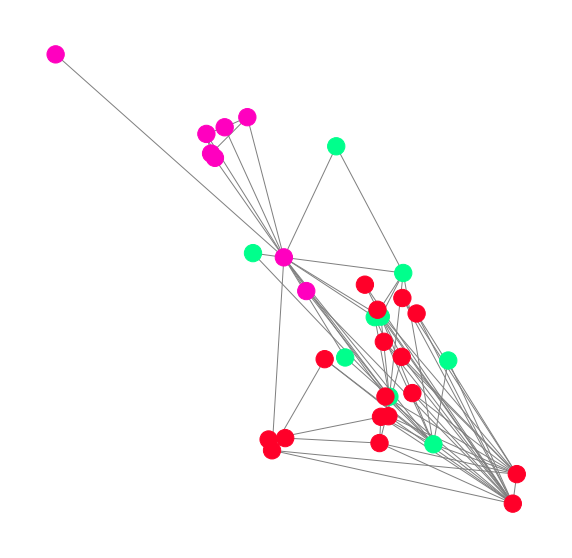

In [49]:
pos = {i: embed[i,:] for i in range(embed.shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

In [50]:
train_nodes = np.array([0, 1, 8])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
opt2 = GradDescentOptim(lr=2e-2, wd=2.5e-2)

In [51]:
embeds = list()
accs = list()
train_losses = list()
test_losses = list()

loss_min = 1e6
es_iters = 0
es_steps = 50
# lr_rate_ramp = 0 #-0.05
# lr_ramp_steps = 1000

for epoch in range(15000):
    
    y_pred = gcn_model.forward(A_hat, X)

    opt2(y_pred, labels, train_nodes)
    
#     if ((epoch+1) % lr_ramp_steps) == 0:
#         opt2.lr *= 1+lr_rate_ramp
#         print(f"LR set to {opt2.lr:.4f}")

    for layer in reversed(gcn_model.layers):
        layer.backward(opt2, update=True)
        
    embeds.append(gcn_model.embedding(A_hat, X))
    # Accuracy for non-training nodes
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
        [i for i in range(labels.shape[0]) if i not in train_nodes]
    ]
    accs.append(acc.mean())
    
    loss = xent(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1
        
    if es_iters > es_steps:
        print("Early stopping!")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")
        
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

Epoch: 1, Train Loss: 1.088, Test Loss: 1.075
Epoch: 101, Train Loss: 1.050, Test Loss: 1.045
Epoch: 201, Train Loss: 1.004, Test Loss: 1.000
Epoch: 301, Train Loss: 0.943, Test Loss: 0.934
Epoch: 401, Train Loss: 0.861, Test Loss: 0.841
Epoch: 501, Train Loss: 0.758, Test Loss: 0.729
Epoch: 601, Train Loss: 0.644, Test Loss: 0.619
Epoch: 701, Train Loss: 0.538, Test Loss: 0.534
Epoch: 801, Train Loss: 0.447, Test Loss: 0.476
Epoch: 901, Train Loss: 0.372, Test Loss: 0.437
Epoch: 1001, Train Loss: 0.308, Test Loss: 0.409
Epoch: 1101, Train Loss: 0.256, Test Loss: 0.389
Epoch: 1201, Train Loss: 0.216, Test Loss: 0.375
Epoch: 1301, Train Loss: 0.184, Test Loss: 0.366
Epoch: 1401, Train Loss: 0.160, Test Loss: 0.360
Epoch: 1501, Train Loss: 0.142, Test Loss: 0.357
Epoch: 1601, Train Loss: 0.128, Test Loss: 0.355
Epoch: 1701, Train Loss: 0.116, Test Loss: 0.354
Epoch: 1801, Train Loss: 0.107, Test Loss: 0.353
Epoch: 1901, Train Loss: 0.100, Test Loss: 0.353
Epoch: 2001, Train Loss: 0.094, 

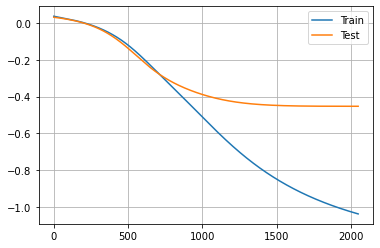

In [52]:
fig, ax = plt.subplots()
ax.plot(np.log10(train_losses), label='Train')
ax.plot(np.log10(test_losses), label='Test')
ax.legend()
ax.grid()

In [53]:
accs[-1]

0.8709677419354839

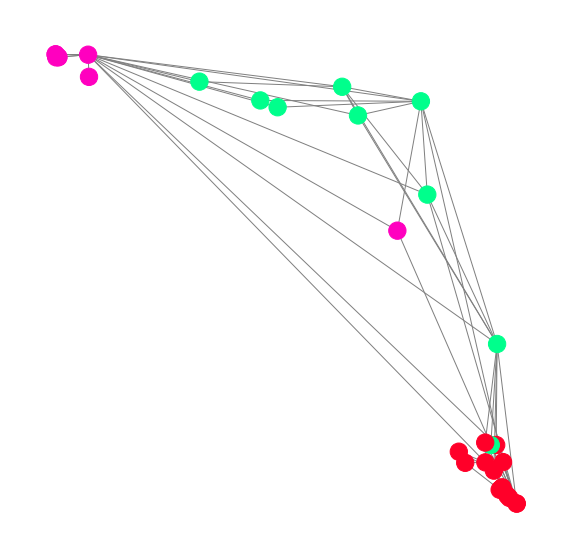

In [54]:
pos = {i: embeds[-1][i,:] for i in range(embeds[-1].shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

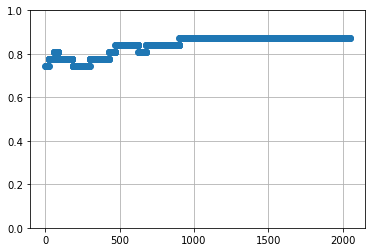

In [55]:
fig, ax = plt.subplots()
_ = ax.plot(accs, marker='o')
ax.grid()
_ = ax.set(ylim=[0,1])

In [58]:
N = 500
snapshots = np.linspace(0, len(embeds)-1, N).astype(int)

c:\Users\saulg\Anaconda3\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


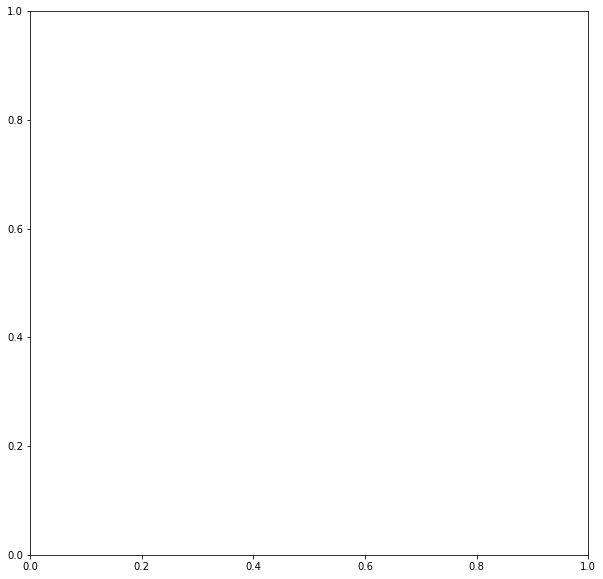

In [60]:
# Build plot
fig, ax = plt.subplots(figsize=(10, 10))
kwargs = {'cmap': 'gist_rainbow', 'edge_color': 'gray', }#'node_size': 55}

from matplotlib import animation

def update(idx):
    ax.clear()
    embed = embeds[snapshots[idx]]
    pos = {i: embed[i,:] for i in range(embed.shape[0])}
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)

anim = animation.FuncAnimation(fig, update, frames=snapshots.shape[0], interval=10, repeat=False)
plt.show()